# Inicialização

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!rm -rf images # Delete the 'images' directory (inside Colab), if it exists
!rm -rf sample_data # Delete the 'sample_data' directory (inside Colab), if it exists

In [ ]:
!pip install pm4py

In [ ]:
!pip install ahpy # Change line 151 of "ahpy" lib from 'self._matrix.itemset(location, value)' to 'self._matrix[location] = value'
                  # OR do the Monkey patch of the function (as done in following lines)

In [ ]:
!pip install pymcdm

In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
import time
import builtins # to use .sum() direct on a list
import matplotlib.pyplot as plt
from pprint import pprint

# To execute sensitivity analysis dynamically
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

In [ ]:
import pm4py

from pm4py.objects.conversion.log import converter as log_converter

from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# https://pm4py-source.readthedocs.io/en/stable/pm4py.algo.discovery.html
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

from pm4py.algo.evaluation import algorithm as evaluation

from pm4py.statistics.variants.log import get as log_statistics

from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer

In [ ]:
import ahpy

In [ ]:
import pymcdm

from pymcdm import visuals
from pymcdm import weights as w
from pymcdm.methods import PROMETHEE_II, TOPSIS, VIKOR
from pymcdm.methods.partial import PROMETHEE_I
from pymcdm.helpers import rrankdata # reverse ranking
from pymcdm.helpers import rankdata
from pymcdm.helpers import correlation_matrix
from pymcdm.correlations import weighted_spearman

Quais as versões das bibliotecas?

In [ ]:
# List the libraries version

In [ ]:
# Function to create the 'images' directory if it doesn't exist
def create_directory(diretorio_local):
  if not os.path.exists(diretorio_local):
    os.makedirs(diretorio_local)

In [ ]:
# Creation the directory where the images will be saved
create_directory('images')

# Módulo leitura do log

In [ ]:
# Select the way that the script will access the data (1. Google Drive; 2. Uploading)
aux_int = 0
while aux_int not in [1, 2]:
  try:
    aux_int = int(input(f'Enter the desired index, being: \n'
                        f'\t1 -> Google Drive connection \n'
                        f'\t2 -> Manual upload\n'))
    if aux_int not in [1, 2]:
      print(f'Invalid option. Please enter 1 or 2.')
  except ValueError:
    print(f'Invalid input. Please enter an integer.')

if aux_int == 1:
  from google.colab import drive
  drive.mount('/content/drive')

  # directory = str(input(f'Please, insert the name of dictories, file and extension (e.g.: Directory x/Directory n/FileName.csv): '))
  directory = 'MyDrive/Logs (Doutorado)/Log_Maquinas_Ajustado.csv'
  file_path = '/content/drive/' + directory

  # file_path = '/content/drive/MyDrive/Logs (Doutorado)/Log_Maquinas_Ajustado.csv' # Usando este aqui como referência
  # file_path = '/content/drive/MyDrive/Logs (Doutorado)/Log_Maquinas_Ajustado_200.csv'

elif aux_int == 2:
  from google.colab import files

  uploaded = files.upload()
  file_path = list(uploaded.keys())[0]

In [ ]:
# Get the time to measure the time spent, in this case, the total time
start_time_of_execution = time.perf_counter() # calc_time_elapsed(start_time_of_execution)

In [ ]:
# Function to calculate the time spent of an execution
def calc_time_elapsed(start_time):
  end_time = time.perf_counter()
  elapsed_time = end_time - start_time

  # Convert elapsed_time to a readable format
  if elapsed_time < 60:
    time_display = f'{elapsed_time:.4f} seconds'
  elif elapsed_time < 3600:
    time_display = f'{elapsed_time / 60:.4f} minutes'
  elif elapsed_time < 86400:
    time_display = f'{elapsed_time / 3600:.4f} hours'
  else:
    time_display = f'{elapsed_time / 86400:.4f} days'

  print(f'Script execution time: {time_display}')

In [ ]:
# Read the data (.csv file) and, then, present the 5-first values
log_csv = pd.read_csv(file_path, sep=';')
log_csv.head()

In [ ]:
# Present the overall information of dataframe's columns
log_csv.info()

# Módulo Mineração de Processos

In [ ]:
# Get the time to measure the time spent, in this case, only in the Process Mining module
start_time_of_execution_PM = time.perf_counter()

In [ ]:
# Create/convert a column in "datetime" to use as input for PM algorithms
log_csv['timestamp'] = pd.to_datetime(log_csv['timestamp'])
log_csv.info()

In [ ]:
# As the log presents "several production lines", we collect his variations by Products
FilterByProduct = log_csv['Produto'].unique()
print(f'{FilterByProduct}')

In [ ]:
 # Create a list with "subarrays" only with unique products (= production line)
dataframe_array = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  dataframe_array[i] = pm4py.format_dataframe(log_csv[log_csv['Produto'] == FilterByProduct[i]], case_id='caseID',
                                              activity_key='taskID',
                                              timestamp_key= 'timestamp',
                                              timest_format='%d-%m-%Y %H:%M:%S')

print(f'Array global type: {type(dataframe_array)} \nArray local type: {type(dataframe_array[0])}')

In [ ]:
# Discover the model using Direct Flow Diagram algorithm
start_act = [None] * len(FilterByProduct)
end_act = [None] * len(FilterByProduct)
dfg = [None] * len(FilterByProduct)
start_activities = [None] * len(FilterByProduct)
end_activities = [None] * len(FilterByProduct)
dfg_image = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  start_act[i] = pm4py.get_start_activities(dataframe_array[i]) # Collect the first activitiy of each subarray / sub-dataframe
  end_act[i] = pm4py.get_end_activities(dataframe_array[i]) # Collect the last / final activitiy of each subarray / sub-dataframe
  print(f'{FilterByProduct[i]} \nFirst Activity: {start_act[i]} \nFinal Activity: {end_act[i]}')

  dfg[i], start_activities[i], end_activities[i] = pm4py.discover_dfg(dataframe_array[i]) # Present the discovered model using Direct Flow Diagram algorithm
  dfg_view = pm4py.view_dfg(dfg[i], start_activities[i], end_activities[i])

  dfg_image[i] = dfg_visualization.apply(dfg[i], log=dataframe_array[i], variant=dfg_visualization.Variants.FREQUENCY) # Save the image
  dfg_visualization.save(dfg_image[i], f'images/Output_DFG_{FilterByProduct[i]}.png')
  print()

In [ ]:
# Convert the dataframe array into event log array
log_EL_array = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  # log_EL_array[i] = pm4py.convert_to_event_log(log_EventLog_array[i])
  log_EL_array[i] = pm4py.convert_to_event_log(dataframe_array[i])

In [ ]:
# Show how many instances / traces / cases there are in the log
for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]} \tNumber of traces: {len(log_EL_array[i])}')

In [ ]:
# Show how many activities there are in the log
event_stream_EL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  event_stream_EL[i] = log_converter.apply(log_EL_array[i], variant=log_converter.Variants.TO_EVENT_STREAM)
  print(f'{FilterByProduct[i]} \tNumber of events: {len(event_stream_EL[i])}')

In [ ]:
# Present only the activities within each subarray
events_EL_array = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  events_EL_array[i] = dataframe_array[i].drop_duplicates(subset='concept:name')
  print(events_EL_array[i]['concept:name'].tolist())
  print(f'-'*50)

In [ ]:
# First and final activity of each subarray
for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  print(f'Start activities: {pm4py.get_start_activities(log_EL_array[i])}') # 1st way of get start / end activity
  print(f'End activities: {pm4py.get_end_activities(log_EL_array[i])}')
  print(f'-'*50)

In [ ]:
# It filters only cases that end with an specific activity, in this case, only "Peca Produzida - Peca Boa"
filtered_log = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  filtered_log[i] = pm4py.filter_end_activities(log_EL_array[i], ['Peca Produzida - Peca Boa'])
  print(filtered_log[i])
  print(f'-'*50)

In [ ]:
# Calculate the number of variants and, as a consequence, the frequency of each
variants_count = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')

  variants_count[i] = log_statistics.get_variants(log_EL_array[i])
  variants_count[i] = sorted(variants_count[i].items(), key=lambda item: len(item[1]), reverse=True)

  # Calculate the number of unique variants
  unique_variants_count = len(variants_count[i])
  print(f'Number of unique variants: {unique_variants_count}')

  # To print the top 10 variants and their counts:
  print(f'Top 10 variants by case number:')
  for variant_info in variants_count[i][:10]:
    print(f'Count: {len(variant_info[1])},\t Variant: {variant_info[0]}')

  print(f'-'*50)

In [ ]:
# Present visually the activities, highlighting which of them starts / ends the cases
# It uses the Alpha Miner algorithm to identify them
a_net = [None] * len(FilterByProduct)
a_initial_marking = [None] * len(FilterByProduct)
a_final_marking = [None] * len(FilterByProduct)
a_gviz = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  a_net[i], a_initial_marking[i], a_final_marking[i] = alpha_miner.apply(dataframe_array[i]) # Alpha Miner
  a_gviz[i] = pn_visualizer.apply(a_net[i], a_initial_marking[i], a_final_marking[i]) # Visualize Alpha Miner
  pn_visualizer.view(a_gviz[i])
  pn_visualizer.save(a_gviz[i], f'images/Alpha Miner_{FilterByProduct[i]}.png')

  print()

In [ ]:
# Present visually / discover the process by using the Heuristics Miner algorithm
h_net = [None] * len(FilterByProduct)
h_initial_marking = [None] * len(FilterByProduct)
h_final_marking = [None] * len(FilterByProduct)
h_gviz = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  h_net[i], h_initial_marking[i], h_final_marking[i] = heuristics_miner.apply(dataframe_array[i]) # Heuristics Miner
  h_gviz[i] = pn_visualizer.apply(h_net[i], h_initial_marking[i], h_final_marking[i]) # Visualize Heuristics Miner
  pn_visualizer.view(h_gviz[i])
  pn_visualizer.save(h_gviz[i], f'images/Heuristics Miner Discovery_{FilterByProduct[i]}.png')

  print()

In [ ]:
# Present visually / discover the process by using the Inductive Miner algorithm
i_net = [None] * len(FilterByProduct)
i_initial_marking = [None] * len(FilterByProduct)
i_final_marking = [None] * len(FilterByProduct)
i_gviz = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  i_net[i] = inductive_miner.apply(dataframe_array[i]) # inductive_miner.apply() only needs 1 parameter, the log file
  i_net[i], i_initial_marking[i], i_final_marking[i] = pm4py.convert_to_petri_net(i_net[i]) # convert to PetriNet
  i_gviz[i] = pn_visualizer.apply(i_net[i], i_initial_marking[i], i_final_marking[i]) # visualize inductive miner
  pn_visualizer.view(i_gviz[i])
  pn_visualizer.save(i_gviz[i], f'images/Inductive Miner_{FilterByProduct[i]}.png')

  print()

In [ ]:
# Responsible for evaluate the (calculate all metrics from) discovered models
# TBR = token-based replay
alpha_result = [None] * len(FilterByProduct)
heuristic_result = [None] * len(FilterByProduct)
inductive_result = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  alpha_result[i] = evaluation.apply(dataframe_array[i], a_net[i], a_initial_marking[i], a_final_marking[i])
  heuristic_result[i] = evaluation.apply(dataframe_array[i], h_net[i], h_initial_marking[i], h_final_marking[i])
  inductive_result[i] = evaluation.apply(dataframe_array[i], i_net[i], i_initial_marking[i], i_final_marking[i])

  print(f'Alpha Miner:'), pprint(alpha_result[i]), print('')
  print(f'Heuristics Miner:'), pprint(heuristic_result[i]), print('')
  print(f'Inductive Miner:'), pprint(inductive_result[i]), print('')
  print('-'*50)

In [ ]:
# Consolidate previous results and present the "average trace fitness" to users
for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]} - Average trace fitness:')
  print(f'Alpha Miner: {alpha_result[i]['fitness']['average_trace_fitness']:.4f} --- '
        f'Heuristic Miner: {heuristic_result[i]['fitness']['average_trace_fitness']:.4f} --- '
        f'Inductive Miner: {inductive_result[i]['fitness']['average_trace_fitness']:.4f}')
  print(f'-'*50)

In [ ]:
# Calculate the number traces of each subarray does not fit the discovered model
# In this case, we choose the Heuristic Miner to test it
replayed_traces = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  # replayed_traces[i] = token_replay.apply(dataframe_array[i], a_net[i], a_initial_marking[i], a_final_marking[i])
  replayed_traces[i] = token_replay.apply(dataframe_array[i], h_net[i], h_initial_marking[i], h_final_marking[i])
  # replayed_traces[i] = token_replay.apply(dataframe_array[i], i_net[i], i_initial_marking[i], i_final_marking[i])

  sum = 0
  for dict in replayed_traces[i]:
    if dict['trace_is_fit'] == False:
      sum += 1

  print(f'Number of traces not fit: {sum}')
  print(f'-'*50)

In [ ]:
# We can partially select the log by filtering only the top "k" variants
short_log = [None] * len(FilterByProduct)

aux = str(input(f'Do you want to filter the top variants (traces)? (y / n) '))
if aux.lower() == 'y':
  k = int(input(f'Enter the value of top traces you want to filter ("k"): '))
  for i in range(len(FilterByProduct)):
    short_log[i] = pm4py.filter_variants_top_k(log_EL_array[i], k)
    print(f'{FilterByProduct[i]} \tNumber of traces: \t'
          f'Top-{k} cases: {len(short_log[i])} \t'
          f'Original: {len(log_EL_array[i])}')
else:
  short_log = log_EL_array.copy()
  for i in range(len(FilterByProduct)):
    print(f'{FilterByProduct[i]} \tNumber of traces: {len(short_log[i])}')

# For here on, the var "short_log" will be used as reference for calculation,
# since it can be used as original OR filtered with only top traces

In [ ]:
# For each subarray, it calculates the pair of activity and its frequency, it also presents the start/final
dfg_discover = [None] * len(FilterByProduct)
start_activities = [None] * len(FilterByProduct)
end_activities = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  # a directly -follows graph (DFG) is discovered from the log
  dfg_discover[i], start_activities[i], end_activities[i] = pm4py.discover_dfg(short_log[i]) # 2nd way of get start / end activity

  print(f'{FilterByProduct[i]}')
  pprint(dfg_discover[i])
  print()
  print(f'Start activity / qtty.: {start_activities[i]}')
  print(f'End activity / qtty.: {end_activities[i]}')
  print(f'-'*50)

In [ ]:
# It uses Inductive Miner to discover and format it to present as: Process Tree, Petri Net, and BPMN diagram
process_tree = [None] * len(FilterByProduct)
bpmn_diagram = [None] * len(FilterByProduct)
petri_net = [None] * len(FilterByProduct)
initial_marking = [None] * len(FilterByProduct)
final_marking = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  # a process tree is discovered using the inductive miner
  process_tree[i] = pm4py.discover_process_tree_inductive(short_log[i])

  petri_net[i], initial_marking[i], final_marking[i] = pm4py.convert_to_petri_net(process_tree[i]) # the process tree is converted to an accepting Petri net

  # the accepting Petri net is converted to a BPMN diagram
  bpmn_diagram[i] = pm4py.convert_to_bpmn(petri_net[i], initial_marking[i], final_marking[i])

In [ ]:
# Count of frequency of each activity for each subarray
activity_counts = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  activity_counts[i] = pm4py.get_event_attribute_values(short_log[i], 'concept:name')
  print(f'{FilterByProduct[i]}')
  pprint(activity_counts[i])
  print('\nObs.: it is counting the start/end of each activity, so, the total amount presented is, approximately, twice the real execution.\n','-'*50)

In [ ]:
# Vizualize the activities as Direct Flow Graph (DFG)
dfg_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  dfg_SL[i] = dfg_visualization.apply(dfg_discover[i], log=short_log[i], variant=dfg_visualization.Variants.FREQUENCY) #here, we are using the "short log" (i.e., with the top-5 variant)
  dfg_visualization.save(dfg_SL[i], f'images/Output_DFG_ShortLog_{FilterByProduct[i]}.png')
  dfg_visualization.view(dfg_SL[i])
  print()

In [ ]:
# Vizualize the activities as Process Tree
process_tree_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  process_tree_SL[i] = pt_visualizer.apply(process_tree[i])
  pt_visualizer.save(process_tree_SL[i], f'images/Output_Process Tree_ShortLog_{FilterByProduct[i]}.png')
  pt_visualizer.view(process_tree_SL[i])
  print()

In [ ]:
# Vizualize the activities as Petri Nets
petrinet_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  petrinet_SL[i] = pn_visualizer.apply(petri_net[i], initial_marking[i], final_marking[i])
  pn_visualizer.save(petrinet_SL[i], f'images/Output_Petri-Net_ShortLog_{FilterByProduct[i]}.png')
  pn_visualizer.view(petrinet_SL[i])
  print()

In [ ]:
# Vizualize the activities as BPMN diagram
bpmn_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  bpmn_SL[i] = bpmn_visualizer.apply(bpmn_diagram[i])
  bpmn_visualizer.save(bpmn_SL[i], f'images/Output_BPMN_NewScript_{FilterByProduct[i]}.png')
  bpmn_visualizer.view(bpmn_SL[i])
  print()

In [ ]:
# Compare the original log vs. the discovered model (Obs.: only for Petri Net object: https://pm4py-source.readthedocs.io/en/stable/pm4py.html)
fitness_SL = [None] * len(FilterByProduct)
precision_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  fitness_SL[i]= pm4py.fitness_token_based_replay(short_log[i], petri_net[i], initial_marking[i], final_marking[i])
  print()
  print(f'Fitness:'),
  pprint(fitness_SL[i])

  precision_SL[i] = pm4py.precision_token_based_replay(short_log[i], petri_net[i], initial_marking[i], final_marking[i])
  print()
  print(f'Precision: {precision_SL[i]  :.4f}')

  print('-'*50)

In [ ]:
# Calculate the duration of each case for each subarray
case_duration = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  case_duration[i] = pm4py.get_all_case_durations(short_log[i])

  print(f'{case_duration[i]}')
  print(f'Qtde. de saídas = {len(case_duration[i])}')

  soma = 0
  for n in range(len(case_duration[i])-1):
    soma = (case_duration[i][n+1] - case_duration[i][n]) + soma

  media = soma / len(case_duration[i])
  print(f'Tempo de ciclo médio (segundos) = {media :.2f}')
  print('-'*50)

In [ ]:
soma = 0
for i in range(len(case_duration[9])-1):
  soma = case_duration[9][i+1] - case_duration[9][i] + soma

media = soma / len(case_duration[9])
media

In [ ]:
# Check if the discovered model is a sound workflow net (Obs.: only for Petri Net object)
is_sound_wfnet = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  is_sound_wfnet[i] = pm4py.check_soundness(petri_net[i], initial_marking[i], final_marking[i])[0]
  print(f'Is the log (or partial log) "{FilterByProduct[i]}" a sound workflow net?\t {is_sound_wfnet[i]}') # True

In [ ]:
# # Another way to discover and present the Petri Net
# pnet = [None] * len(FilterByProduct)
# pnet_initial_marking = [None] * len(FilterByProduct)
# pnet_final_marking = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   # Discover Petri net using the inductive miner and Visualize it
#   pnet[i], pnet_initial_marking[i], pnet_final_marking[i] = pm4py.discover_petri_net_inductive(short_log[i])
#   pm4py.view_petri_net(pnet[i], pnet_initial_marking[i], pnet_final_marking[i])
#   print()

In [ ]:
# # Filter the log (if needed) according to the case performance
# filtered_log = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   # for filtering based on performance filters
#   filtered_log[i] = pm4py.filter_case_performance(short_log[i], min_performance=100, max_performance=1000)

## In the current log context, we have...

In [ ]:
# Function to calculate the time spent for each activity
def get_activity_durations_minutes(LogEventos_df):
  activity_durations = {}

  events_EL = LogEventos_df.drop_duplicates(subset='taskID')
  events_text = events_EL['taskID'].tolist()
  events_text.sort()

  for case_id, case in LogEventos_df.groupby('caseID'):
    activity_start_times = {}
    for index, event in case.iterrows():
      activity_name = event['taskID']
      timestamp = event['timestamp']
      lifecycle_transition = event.get('eventtype') # Assuming 'eventtype' exists

      if lifecycle_transition == 'start': # markers of beginning
        activity_start_times[activity_name] = timestamp
      elif lifecycle_transition == 'complete' and activity_name in activity_start_times: # markers of ending
        duration = timestamp - activity_start_times[activity_name]
        if activity_name not in activity_durations:
          activity_durations[activity_name] = []
        activity_durations[activity_name].append(duration)

  activity_total_time = {}
  for act in events_EL['taskID'].tolist():
    if act in activity_durations:
      tempo = pd.Series(activity_durations[act])
      # total_time = tempo.sum() # Variable in timedelta
      total_time = tempo.sum().total_seconds()/60 # Convert timedelta to minutes (.../60)
    else:
      # total_time = pd.Timedelta(seconds=0) # Set time to 0 if activity not in dictionary
      total_time = 0.0 # Set time to 0.0 if activity not in dictionary
    activity_total_time[act] = total_time

  return activity_total_time, events_text

In [ ]:
# Calculate the KPI related to no. of stops (failures or stops) during execution
c3_stop = [None] * len(FilterByProduct)
c3_fail = [None] * len(FilterByProduct)
c3 = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  df_produto1 = log_csv[log_csv['Produto'] == FilterByProduct[i]] # we SHOULD use the Event Log variable, without filtering

  # 1/2 (0.5) -> It multiplies by .5 because the function counts the "start" and "complete" event
  c3_stop[i] = 1/2 * (df_produto1[df_produto1['taskID'] == 'Falha durante o trabalho'].shape[0])
  c3_fail[i] = 1/2 * (df_produto1[df_produto1['taskID'] == 'Parada Operacional'].shape[0])
  c3[i] = (c3_stop[i] + c3_fail[i])
  print(f'Number of stops for {FilterByProduct[i]}: \t{c3[i]}')

In [ ]:
# Calculation of some KPIs (it will be used to MTBF and MTTR)
FailRate = [None] * len(FilterByProduct) # c1
MTBF = [None] * len(FilterByProduct)
MTTR = [None] * len(FilterByProduct) # c2
up_time = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')

  act_time, events_name = get_activity_durations_minutes(dataframe_array[i]) # we SHOULD use the dataframe variable, without filtering
  pprint(act_time)

  up_time[i] = act_time['Trabalhar'] + act_time['Setup'] + act_time['Retirar Produto'] + act_time['Parada Operacional']

  MTBF[i] = up_time[i] / c3_stop[i]
  FailRate[i] = 1 / MTBF[i]

  MTTR[i] = act_time['Falha durante o trabalho'] / c3_stop[i]

  print()
  print(f'Production (uptime): {up_time[i] :.2f} \t MTBF: {MTBF[i] :.3f} \t Failure rate: {FailRate[i] :.3f} \t MTTR: {MTTR[i] :.3f} \t Failure No.: {c3[i]}')
  print('\n', '-'*50)

In [ ]:
# It presents how long it took to run this module
print(f'Process Mining Module - Time of Execution:')
calc_time_elapsed(start_time_of_execution_PM)

# Módulo AHP

Monkey patch
*   from '***self._matrix.itemset(location, value)***'
*   to '***self._matrix[location] = value***'

In [ ]:
# Get the time to measure the time spent, in this case, only in the AHP Method module
start_time_of_execution_AHP = time.perf_counter()

In [ ]:
# Do the "Monkey patch" of a function inside an external library that changes the way it is called after a new release of Numpy
from unittest import mock
# import ahpy # Replace with the actual library you're patching

print(f'NumPy version running "{np.__version__}" vs. Recommended version to use "1.26.4" OR do the Monkey patching.')
print(f'In the current script, we are performing the "Monkey patching" of a function, since the way it is called has changed.')

def new_build_matrix(self):
  self._matrix = np.ones((self._size, self._size))
  for pair, value in self._pairs.items():
    location = tuple(self._elements.index(elements) for elements in pair)
    # Use array indexing instead of itemset
    self._matrix[location] = value

# Monkey patch the ahpy.Compare class
ahpy.Compare._build_matrix = new_build_matrix

In [ ]:
# Get the qtty of criteria and its respective names
def get_matrix_name(name):
  fn_list_criteria = []
  typeMinMax = []
  while True:
    try:
      fn_num_criteria = int(input(f'Enter the number of {name} to be inserted: '))
      break # Exit the loop if input is a valid integer
    except ValueError:
      print(f'Invalid input. Please enter a number.')

  for n in range(fn_num_criteria):
    aux_str = str(input(f'Type the name of {name} {(n+1):.0f}: '))

    while aux_str in fn_list_criteria:
      print(f'This name already exist. Please input a new one!')
      aux_str = str(input(f'Type the name of {name} {(n+1):.0f}: '))

    fn_list_criteria.append(aux_str)

    while True:
      try:
        obj_input = int(input(f'Which is the objective of "{fn_list_criteria[n]}" criterion (Min = -1 OR Max = 1)? '))
        if obj_input in [-1, 1]:
          typeMinMax.append(obj_input)
          break # Exit the loop if input is a valid integer and is -1 or 1
        else:
          print('Invalid input. Please enter -1 for Min or 1 for Max.')
      except ValueError:
        print(f'Invalid input. Please enter a number.')

  fn_list_criteria_pairs = list(itertools.combinations(fn_list_criteria, 2))
  return fn_num_criteria, typeMinMax, fn_list_criteria, fn_list_criteria_pairs

In [ ]:
# Peer-to-peer comparison between criteria
def get_matrix_values(list_of_criteria_pairs):
  matrix_weights = {}
  n = 0
  for pair in list_of_criteria_pairs:
    while True:  # Loop until valid input is received
      aux_str = str(input(f'Insert the relevance value (weight) of criterion 1 in relation to criterion 2 -> {list_of_criteria_pairs[n]}: '))
      try:
        if '/' in aux_str:
          index = aux_str.find('/')
          numerador = float(aux_str[:index])
          denominador = float(aux_str[index+1:])
          value = float(numerador / denominador)
        else:
          value = float(aux_str)
        matrix_weights[pair] = value
        break  # Exit the loop if input is valid
      except ValueError:
        print(f'Invalid input. Please enter a number or a fraction (e.g., 3 or 1/2).')
      except ZeroDivisionError:
        print(f'Invalid input. The denominator of a fraction cannot be zero.')

    n += 1
  return matrix_weights

In [ ]:
# Get the qtty, names and peer-to-peer criteria list
qtde_criteria, MinMax, list_criteria, list_criteria_pairs = get_matrix_name('Criteria')
print(f'-'*50)
print(f'List of criteria: {list_criteria} --- Criteria qtty: {qtde_criteria}\n')
print(f'Type of criteria (MinMax): {MinMax}\n')
print(f'List of criteria (peer-to-peer):')
pprint(list_criteria_pairs)

In [ ]:
# Peer-to-peer criteria comparisons
criteria_comparisons = get_matrix_values(list_criteria_pairs) # 1/3 1/5 5 3 1 7 5 7 7 3

# pprint(criteria_comparisons)
# criteria_comparisons.values()
# criteria_comparisons.keys()

In [ ]:
# Check if consistency ratio is acceptable and question user if he/she wants to proceed or not (if higher than expected)
criteria = ahpy.Compare('Criteria and Weights', criteria_comparisons, random_index='saaty') # random_index='saaty' OR 'dd' < https://pypi.org/project/ahpy/#the-compare-class >

while criteria.consistency_ratio > 0.1:
  aux = str(input(f'Consistency ratio (CR) is over 0.1 (10%) [CR = {criteria.consistency_ratio}]. \nDo you want to redo the comparisons? (y / n) '))
  print()

  if aux.lower() == 'y':
    criteria_comparisons = get_matrix_values(list_criteria_pairs)
    criteria = ahpy.Compare('Criteria and Weights', criteria_comparisons, random_index='saaty')
  else:
    print(f'Your consistency ratio (CR) is higher than expected. CR obtained = {criteria.consistency_ratio} vs. Expected <= 0.1')
    break

print()
print(f'Consistency Ratio (CR): {criteria.consistency_ratio} < {criteria.consistency_ratio *100 :.2f}% >')

In [ ]:
# Present the weight of each criteria
report = criteria.report()
pprint(report)

In [ ]:
# Access the weights within dictionary (see above)
criteria.target_weights

In [ ]:
# # It shows the higher criteria and its current weight
# first_criterion_name = list(criteria.target_weights.keys())[0] # [:] if all keys
# first_criterion_weight = list(criteria.target_weights.values())[0] # [:] if all values

# print(f'First criterion name: {first_criterion_name}')
# print(f'First criterion weight: {first_criterion_weight}')

In [ ]:
# It presents how long it took to run this module
print(f'Criteria Weighting Module (by AHP Method) - Time of Execution:')
calc_time_elapsed(start_time_of_execution_AHP)

# Módulo PROMETHEE II

In [ ]:
# Get the time to measure the time spent, in this case, only in the PROMETHEE II module
start_time_of_execution_PROMETHEE = time.perf_counter()

In [ ]:
# Function to input the values for a criterion
def input_criterion_values(criterion_name):
  criterion = None
  while criterion is None or len(criterion) != len(FilterByProduct):
    aux = input(f'Insert the values for criterion "{criterion_name}" (in an array format, but separated ONLY by comma): ')
    try:
      criterion = np.array([float(x) for x in aux.split(',')])
      if len(criterion) != len(FilterByProduct):
        print(f'The number of values entered ({len(criterion)}) does not match the number of alternatives ({len(FilterByProduct)}). Please try again.')
    except ValueError:
      print('Invalid input. Please enter numbers separated ONLY by commas.')
  return criterion

Possível deixar de forma iterativa considerando a variável "qtde_criteria" como referência?

In [ ]:
# It fills out all the criteria with quali/quanti measures --- for our case, 5 (five) criteria
aux = str(input(f'Do you want to manually enter the values for all the criteria? (y / n) '))
if aux.lower() == 'n': # edit considering the qtty of criterion the problem will have
  c1 = FailRate.copy()
  c2 = MTTR.copy()
  c3 = c3.copy()

  print(f'\nEntering the values only for qualitative criterion...\n')
  c4 = list(input_criterion_values('c4')) # 3,5,1,3,2,3,4,3,1,3
  c5 = list(input_criterion_values('c5')) # 2,4,1,3,4,5,1,4,2,2
else: # edit considering the qtty of criterion the problem will have
  c1 = list(input_criterion_values('c1')) # 0.025,0.040,0.016,0.048,0.033,0.010,0.048,0.065,0.010,0.024
  c2 = list(input_criterion_values('c2')) # 3.538,3.947,4.261,7.800,5.700,6.267,7.800,4.640,6.267,6.375
  c3 = list(input_criterion_values('c3')) # 66,74,78,75,80,77,75,83,77,73
  c4 = list(input_criterion_values('c4')) # 3,5,1,3,2,3,4,3,1,3
  c5 = list(input_criterion_values('c5')) # 2,4,1,3,4,5,1,4,2,2

avaliar se a ordem alfabética influencia neste fase (por ordem de inserção (no método AHP) ou por ordem alfabética?)

In [ ]:
# # Sort the dictionary by key
# CriteriaByName = sorted(criteria.target_weights.items())

In [ ]:
# Execute the PROMETHEE II method on the matrix considering the body (function type),
# the matrix with measures, criteria weighting, and type of each criterion
body = PROMETHEE_II('usual')

matrix = np.array([
    [round(c1[i],4),
     round(c2[i],4),
     int(c3[i]),
     int(c4[i]),
     int(c5[i])] for i in range(len(FilterByProduct))
])

# weights = [item[1] for item in CriteriaByName]
# weights = np.array([.1270, .2696, .2120, .1697, .2217])
# weights = [.2, .2, .2, .2, .2]

weights = np.array([criteria.target_weights[c] for c in list_criteria])
print(f'Weights (from AHP): {weights}')

MinMax_array = MinMax
print(f'Criteria objective: {MinMax_array}')

[round(preference, 4) for preference in body(matrix, weights, MinMax_array)]

In [ ]:
# Execute the PROMETHEE II method on the matrix considering the body (function type),
# the matrix with measures, criteria weighting, and type of each criterion
pref = body(matrix, weights, MinMax_array)
ranking = rrankdata(pref)

for r, p, i in zip(ranking, pref, range(len(FilterByProduct))):
  print(f'{FilterByProduct[i]}', '\t', 'Position: ', r, '\t', round(p, 4))

In [ ]:
# Plot the distribution of the net flow (phi value) as box plot
plt.boxplot(pref)
plt.title(f'Box Plot')
plt.ylabel(f'Resulting net flow (phi value) variation')
plt.xticks([1], ['PROMETHEE II'])
plt.savefig('images/PROMETHEE II_PhiValue_BoxPlot.png', bbox_inches='tight') # Added line to save the figure
plt.show()

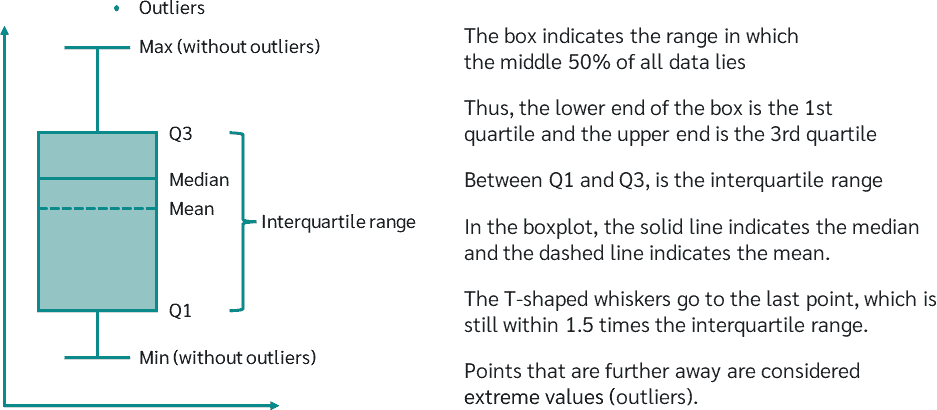

In [ ]:
# Create groups of classification, where in each quantile an specific strategy of maintenance is suggested
# Classify the net flow of each alternatives according to this group limits
problem_quantiles = np.quantile(pref, [0, 0.25, 0.5, 0.75, 1])
print(f'Quantiles of PROMETHEE II net flow (phi): \n{problem_quantiles}')
print(f'-'*50)

# Categorize pref values based on quantiles
categories = []
for value in pref:
  if value <= problem_quantiles[1]:
    categories.append('1. Preventive Maintenance (PvM)')
  elif value <= problem_quantiles[2]:
    categories.append('2. Condition-Based Maintenance (CBM)')
  elif value <= problem_quantiles[3]:
    categories.append('3. Predictive Maintenance (PdM)')
  else:
    categories.append('4. Prescriptive Maintenance (RxM)')

# Display the values and their categories
for i in range(len(pref)):
  print(f'Product{i+1}: {pref[i]:.4f}\t Category: {categories[i]}')

In [ ]:
# Group the values by maintenance strategy
maintenance_strategy = zip(FilterByProduct, categories)
maintenance_strategy_dict = {}
for product, category in maintenance_strategy:
  if category not in maintenance_strategy_dict:
    maintenance_strategy_dict[category] = []
  maintenance_strategy_dict[category].append(product)

pprint(maintenance_strategy_dict)

In [ ]:
# It presents how long it took to run this module
print(f'MCDM Module (by PROMETHEE II Method) - Time of Execution:')
calc_time_elapsed(start_time_of_execution_PROMETHEE)

# Sensitivity Analysis

In [ ]:
def plot_promethee_ranking(matrix_func, weights_AHP, MinMax_func, w1, w2, w3, w4, w5,qtde_criteria_func):
  methods = [PROMETHEE_II('usual'), PROMETHEE_II('usual')]
  method_names = ['PROMETHEE II', 'PROMETHEE II \n(after sensitivity analysis)']

  prefs = []
  ranks = []

  weights_func = [None] * 2
  weights_func[0] = weights_AHP.copy()
  print(f'Weights (from AHP method):\t{weights_AHP}')

  weights_func[1] = np.array([w1, w2, w3, w4, w5])

  if np.sum(weights_func[1]) == 0:
    print(f'Unable to proceed. All the weights are set to 0 (zero), which is not possible!')
  else:
    weights_func[1] = weights_func[1] / np.sum(weights_func[1]) # Normalize weights

    i=0 # index '0' will be weights from AHP and '1' will be weights of 'sensitivity analysis'
    for method in methods:
      pref = method(matrix_func, weights_func[i], MinMax_func)
      rank = method.rank(pref)

      prefs.append(pref)
      ranks.append(rank)
      i+=1

    weights_func[1] = weights_func[1].round(3)
    print(f'Weights (from user entries):\t{weights_func[1]}')

    fig, ax = plt.subplots(figsize=(7, 4), dpi=150, tight_layout=True)
    visuals.ranking_flows(ranks, labels=method_names, ax=ax)
    ax.set_title(f'PROMETHEE II Ranking - Sensitivity Analysis:\n'
                f'Weights (from AHP): {weights_func[0].round(3)}\n'
                f'Weights (user entries): {weights_func[1]}')
    plt.savefig('images/Sensitivity Analysis from PROMETHEE II.png', bbox_inches='tight')
    plt.show()

In [ ]:
aux = str(input(f'Do you want to configure manually the step of the slider (standard step: 5%)? (y / n) '))
if aux.lower() == 'y': # edit considering the qtty of criterion the problem will have
  while True:
    try:
      step_of_slider = int(input(f'Insert the step of slider (0 < step < 100): '))
      if 0 < step_of_slider < 100:
        break
      else:
        print(f'Value must be between 1 and 99.')
    except ValueError:
      print(f'Invalid input. Please enter a number.')
else: # edit considering the qtty of criterion the problem will have
  step_of_slider = 5

step_of_slider = step_of_slider / 100

In [ ]:
w1_slider = widgets.FloatSlider(description=f'{list_criteria[0]}:', min=0.0, max=1.0, value=weights[0], step=step_of_slider)
w2_slider = widgets.FloatSlider(description=f'{list_criteria[1]}:', min=0.0, max=1.0, value=weights[1], step=step_of_slider)
w3_slider = widgets.FloatSlider(description=f'{list_criteria[2]}:', min=0.0, max=1.0, value=weights[2], step=step_of_slider)
w4_slider = widgets.FloatSlider(description=f'{list_criteria[3]}:', min=0.0, max=1.0, value=weights[3], step=step_of_slider)
w5_slider = widgets.FloatSlider(description=f'{list_criteria[4]}:', min=0.0, max=1.0, value=weights[4], step=step_of_slider)

In [ ]:
interact(plot_promethee_ranking, # call the function
         matrix_func=widgets.fixed(matrix),
         weights_AHP=widgets.fixed(weights),
         MinMax_func=widgets.fixed(MinMax_array),
         w1=w1_slider, w2=w2_slider, w3=w3_slider, w4=w4_slider, w5=w5_slider,
         qtde_criteria_func=widgets.fixed(qtde_criteria))

# Test (3)

In [ ]:
# Choose a product to modify
chosen_product = 'Produto1' # You can change this to any product in FilterByProduct

# Filter the log for the chosen product
product_log = log_csv[log_csv['Produto'] == chosen_product].copy()

# Get the unique case IDs for the chosen product
case_ids = product_log['caseID'].unique()

# Determine the number of cases to modify (at least 50%)
num_cases_to_modify = max(1, int(len(case_ids) * 0.5))

# Randomly select case IDs to modify
cases_to_modify = np.random.choice(case_ids, size=num_cases_to_modify, replace=False)

# Define the time delta to add (e.g., 30 minutes)
time_delta = pd.Timedelta(minutes=30)

# Iterate through the selected cases and modify the timestamps
for case_id in cases_to_modify:
    # Select events for the current case
    case_events_indices = product_log[product_log['caseID'] == case_id].index

    # Add the time delta to all timestamps within the case
    log_csv.loc[case_events_indices, 'timestamp'] = log_csv.loc[case_events_indices, 'timestamp'] + time_delta

print(f"Modified timestamps for {num_cases_to_modify} cases of {chosen_product}.")

In [ ]:
# Re-run Process Mining Module
start_time_of_execution_PM = time.perf_counter()

log_csv['timestamp'] = pd.to_datetime(log_csv['timestamp'])

FilterByProduct = log_csv['Produto'].unique()

dataframe_array = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  dataframe_array[i] = pm4py.format_dataframe(log_csv[log_csv['Produto'] == FilterByProduct[i]], case_id='caseID',
                                              activity_key='taskID',
                                              timestamp_key= 'timestamp',
                                              timest_format='%d-%m-%Y %H:%M:%S')

start_act = [None] * len(FilterByProduct)
end_act = [None] * len(FilterByProduct)
dfg = [None] * len(FilterByProduct)
start_activities = [None] * len(FilterByProduct)
end_activities = [None] * len(FilterByProduct)
dfg_image = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  start_act[i] = pm4py.get_start_activities(dataframe_array[i])
  end_act[i] = pm4py.get_end_activities(dataframe_array[i])
  print(f'{FilterByProduct[i]} \nFirst Activity: {start_act[i]} \nFinal Activity: {end_act[i]}')

  dfg[i], start_activities[i], end_activities[i] = pm4py.discover_dfg(dataframe_array[i])
  dfg_view = pm4py.view_dfg(dfg[i], start_activities[i], end_activities[i])

  dfg_image[i] = dfg_visualization.apply(dfg[i], log=dataframe_array[i], variant=dfg_visualization.Variants.FREQUENCY)
  dfg_visualization.save(dfg_image[i], f'images/Output_DFG_{FilterByProduct[i]}.png')
  print()

log_EL_array = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  log_EL_array[i] = pm4py.convert_to_event_log(dataframe_array[i])

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]} \tNumber of traces: {len(log_EL_array[i])}')

# event_stream_EL = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   event_stream_EL[i] = log_converter.apply(log_EL_array[i], variant=log_converter.Variants.TO_EVENT_STREAM)
#   print(f'{FilterByProduct[i]} \tNumber of events: {len(event_stream_EL[i])}')

# events_EL_array = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   events_EL_array[i] = dataframe_array[i].drop_duplicates(subset='concept:name')
#   print(events_EL_array[i]['concept:name'].tolist())
#   print(f'-'*50)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   print(f'Start activities: {pm4py.get_start_activities(log_EL_array[i])}')
#   print(f'End activities: {pm4py.get_end_activities(log_EL_array[i])}')
#   print(f'-'*50)

# filtered_log = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   filtered_log[i] = pm4py.filter_end_activities(log_EL_array[i], ['Peca Produzida - Peca Boa'])
#   print(filtered_log[i])
#   print(f'-'*50)

# variants_count = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')

#   variants_count[i] = log_statistics.get_variants(log_EL_array[i])
#   variants_count[i] = sorted(variants_count[i].items(), key=lambda item: len(item[1]), reverse=True)

#   unique_variants_count = len(variants_count[i])
#   print(f'Number of unique variants: {unique_variants_count}')

#   print(f'Top 10 variants by case number:')
#   for variant_info in variants_count[i][:10]:
#     print(f'Count: {len(variant_info[1])},\t Variant: {variant_info[0]}')

#   print(f'-'*50)

# a_net = [None] * len(FilterByProduct)
# a_initial_marking = [None] * len(FilterByProduct)
# a_final_marking = [None] * len(FilterByProduct)
# a_gviz = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   a_net[i], a_initial_marking[i], a_final_marking[i] = alpha_miner.apply(dataframe_array[i])
#   a_gviz[i] = pn_visualizer.apply(a_net[i], a_initial_marking[i], a_final_marking[i])
#   pn_visualizer.view(a_gviz[i])
#   pn_visualizer.save(a_gviz[i], f'images/Alpha Miner_{FilterByProduct[i]}.png')

#   print()

# h_net = [None] * len(FilterByProduct)
# h_initial_marking = [None] * len(FilterByProduct)
# h_final_marking = [None] * len(FilterByProduct)
# h_gviz = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   h_net[i], h_initial_marking[i], h_final_marking[i] = heuristics_miner.apply(dataframe_array[i])
#   h_gviz[i] = pn_visualizer.apply(h_net[i], h_initial_marking[i], h_final_marking[i])
#   pn_visualizer.view(h_gviz[i])
#   pn_visualizer.save(h_gviz[i], f'images/Heuristics Miner Discovery_{FilterByProduct[i]}.png')

#   print()

# i_net = [None] * len(FilterByProduct)
# i_initial_marking = [None] * len(FilterByProduct)
# i_final_marking = [None] * len(FilterByProduct)
# i_gviz = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   i_net[i] = inductive_miner.apply(dataframe_array[i])
#   i_net[i], i_initial_marking[i], i_final_marking[i] = pm4py.convert_to_petri_net(i_net[i])
#   i_gviz[i] = pn_visualizer.apply(i_net[i], i_initial_marking[i], i_final_marking[i])
#   pn_visualizer.view(i_gviz[i])
#   pn_visualizer.save(i_gviz[i], f'images/Inductive Miner_{FilterByProduct[i]}.png')

#   print()

# alpha_result = [None] * len(FilterByProduct)
# heuristic_result = [None] * len(FilterByProduct)
# inductive_result = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')
#   alpha_result[i] = evaluation.apply(dataframe_array[i], a_net[i], a_initial_marking[i], a_final_marking[i])
#   heuristic_result[i] = evaluation.apply(dataframe_array[i], h_net[i], h_initial_marking[i], h_final_marking[i])
#   inductive_result[i] = evaluation.apply(dataframe_array[i], i_net[i], i_initial_marking[i], i_final_marking[i])

#   print(f'Alpha Miner:'), pprint(alpha_result[i]), print('')
#   print(f'Heuristics Miner:'), pprint(heuristic_result[i]), print('')
#   print(f'Inductive Miner:'), pprint(inductive_result[i]), print('')
#   print('-'*50)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]} - Average trace fitness:')
#   print(f'Alpha Miner: {alpha_result[i]['fitness']['average_trace_fitness']:.4f} --- '
#         f'Heuristic Miner: {heuristic_result[i]['fitness']['average_trace_fitness']:.4f} --- '
#         f'Inductive Miner: {inductive_result[i]['fitness']['average_trace_fitness']:.4f}')
#   print(f'-'*50)

# replayed_traces = [None] * len(FilterByProduct)

# for i in range(len(FilterByProduct)):
#   print(f'{FilterByProduct[i]}')s
#   replayed_traces[i] = token_replay.apply(dataframe_array[i], h_net[i], h_initial_marking[i], h_final_marking[i])

#   sum = 0
#   for dict in replayed_traces[i]:
#     if dict['trace_is_fit'] == False:
#       sum += 1

#   print(f'Number of traces not fit: {sum}')
#   print(f'-'*50)

short_log = log_EL_array.copy()
for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]} \tNumber of traces: {len(short_log[i])}')


dfg_discover = [None] * len(FilterByProduct)
start_activities = [None] * len(FilterByProduct)
end_activities = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  dfg_discover[i], start_activities[i], end_activities[i] = pm4py.discover_dfg(short_log[i])

  print(f'{FilterByProduct[i]}')
  pprint(dfg_discover[i])
  print()
  print(f'Start activity / qtty.: {start_activities[i]}')
  print(f'End activity / qtty.: {end_activities[i]}')
  print(f'-'*50)

process_tree = [None] * len(FilterByProduct)
bpmn_diagram = [None] * len(FilterByProduct)
petri_net = [None] * len(FilterByProduct)
initial_marking = [None] * len(FilterByProduct)
final_marking = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  process_tree[i] = pm4py.discover_process_tree_inductive(short_log[i])
  petri_net[i], initial_marking[i], final_marking[i] = pm4py.convert_to_petri_net(process_tree[i])
  bpmn_diagram[i] = pm4py.convert_to_bpmn(petri_net[i], initial_marking[i], final_marking[i])

activity_counts = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  activity_counts[i] = pm4py.get_event_attribute_values(short_log[i], 'concept:name')
  print(f'{FilterByProduct[i]}')
  pprint(activity_counts[i])
  print('\nObs.: it is counting the start/end of each activity, so, the total amount presented is, approximately, twice the real execution.\n','-'*50)

dfg_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  dfg_SL[i] = dfg_visualization.apply(dfg_discover[i], log=short_log[i], variant=dfg_visualization.Variants.FREQUENCY)
  dfg_visualization.save(dfg_SL[i], f'images/Output_DFG_ShortLog_{FilterByProduct[i]}.png')
  dfg_visualization.view(dfg_SL[i])
  print()

process_tree_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  process_tree_SL[i] = pt_visualizer.apply(process_tree[i])
  pt_visualizer.save(process_tree_SL[i], f'images/Output_Process Tree_ShortLog_{FilterByProduct[i]}.png')
  pt_visualizer.view(process_tree_SL[i])
  print()

petrinet_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  petrinet_SL[i] = pn_visualizer.apply(petri_net[i], initial_marking[i], final_marking[i])
  pn_visualizer.save(petrinet_SL[i], f'images/Output_Petri-Net_ShortLog_{FilterByProduct[i]}.png')
  pn_visualizer.view(petrinet_SL[i])
  print()

bpmn_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  bpmn_SL[i] = bpmn_visualizer.apply(bpmn_diagram[i])
  bpmn_visualizer.save(bpmn_SL[i], f'images/Output_BPMN_NewScript_{FilterByProduct[i]}.png')
  bpmn_visualizer.view(bpmn_SL[i])
  print()

fitness_SL = [None] * len(FilterByProduct)
precision_SL = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  fitness_SL[i]= pm4py.fitness_token_based_replay(short_log[i], petri_net[i], initial_marking[i], final_marking[i])
  print()
  print(f'Fitness:'),
  pprint(fitness_SL[i])

  precision_SL[i] = pm4py.precision_token_based_replay(short_log[i], petri_net[i], initial_marking[i], final_marking[i])
  print()
  print(f'Precision: {precision_SL[i]  :.4f}')

  print('-'*50)

case_duration = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')
  case_duration[i] = pm4py.get_all_case_durations(short_log[i])

  print(f'{case_duration[i]}')
  print(f'Qtde. de saídas = {len(case_duration[i])}')

  soma = 0
  for n in range(len(case_duration[i])-1):
    soma = (case_duration[i][n+1] - case_duration[i][n]) + soma

  media = soma / len(case_duration[i])
  print(f'Tempo de ciclo médio (segundos) = {media :.2f}')
  print('-'*50)

is_sound_wfnet = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  is_sound_wfnet[i] = pm4py.check_soundness(petri_net[i], initial_marking[i], final_marking[i])[0]
  print(f'Is the log (or partial log) "{FilterByProduct[i]}" a sound workflow net?\t {is_sound_wfnet[i]}')

print(f'Process Mining Module - Time of Execution:')
calc_time_elapsed(start_time_of_execution_PM)

# Re-run MCDM Module
start_time_of_execution_MCDM = time.perf_counter()

c3_stop = [None] * len(FilterByProduct)
c3_fail = [None] * len(FilterByProduct)
c3 = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  df_produto1 = log_csv[log_csv['Produto'] == FilterByProduct[i]]
  c3_stop[i] = 1/2 * (df_produto1[df_produto1['taskID'] == 'Falha durante o trabalho'].shape[0])
  c3_fail[i] = 1/2 * (df_produto1[df_produto1['taskID'] == 'Parada Operacional'].shape[0])
  c3[i] = (c3_stop[i] + c3_fail[i])
  print(f'Number of stops for {FilterByProduct[i]}: \t{c3[i]}')

FailRate = [None] * len(FilterByProduct)
MTBF = [None] * len(FilterByProduct)
MTTR = [None] * len(FilterByProduct)
up_time = [None] * len(FilterByProduct)

for i in range(len(FilterByProduct)):
  print(f'{FilterByProduct[i]}')

  act_time, events_name = get_activity_durations_minutes(dataframe_array[i])
  pprint(act_time)

  up_time[i] = act_time['Trabalhar'] + act_time['Setup'] + act_time['Retirar Produto'] + act_time['Parada Operacional']

  MTBF[i] = up_time[i] / c3_stop[i]
  FailRate[i] = 1 / MTBF[i]

  MTTR[i] = act_time['Falha durante o trabalho'] / c3_stop[i]

  print()
  print(f'Production (uptime): {up_time[i] :.2f} \t MTBF: {MTBF[i] :.3f} \t Failure rate: {FailRate[i] :.3f} \t MTTR: {MTTR[i] :.3f} \t Failure No.: {c3[i]}')
  print('\n', '-'*50)

methods = [PROMETHEE_II('usual'), TOPSIS(), VIKOR()]
method_names = ['PROMETHEE II', 'TOPSIS', 'VIKOR']

c1 = FailRate.copy()
c2 = MTTR.copy()
c3 = c3.copy()

# Assuming c4 and c5 are still manually entered or derived from other parts of the log
# If they are dependent on timestamps, you would need to re-calculate them here as well
# For now, I will use the previously entered values for c4 and c5
c4 = [3,5,1,3,2,3,4,3,1,3]
c5 = [2,4,1,3,4,5,1,4,2,2]


matrix = np.array([
    [round(c1[i],4),
     round(c2[i],4),
     int(c3[i]),
     int(c4[i]),
     int(c5[i])] for i in range(len(FilterByProduct))
])

weights = np.array([criteria.target_weights[c] for c in list_criteria])
MinMax_array = MinMax

pref_mcdm = []
rank_mcdm = []

for method in methods:
  pref_aux = method(matrix, weights, MinMax_array)
  rank_aux = method.rank(pref_aux)

  pref_mcdm.append(pref_aux)
  rank_mcdm.append(rank_aux)

a = [f'Mach. {i+1}' for i in range(len(pref_mcdm[0]))]
final_results_mcdm = pd.DataFrame(zip(*pref_mcdm), columns=method_names, index=a).round(4)
display(final_results_mcdm)

final_results_mcdm_byRank = pd.DataFrame(zip(*rank_mcdm), columns=method_names, index=a).astype('int')
display(final_results_mcdm_byRank)

plt.boxplot(final_results_mcdm)
plt.title(f'Box Plot')
plt.ylabel(f'Method Result')
plt.xticks([1, 2, 3], method_names)
plt.show()

fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.ranking_bar(rank_mcdm, labels=method_names, ax=ax)
plt.savefig('images/ranking_bar.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.ranking_flows(rank_mcdm, labels=method_names, ax=ax)
plt.savefig('images/ranking_flows.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5), dpi=150, tight_layout=True, subplot_kw={'projection': 'polar'})
visuals.polar_plot(rank_mcdm, labels=method_names, legend_ncol=2, ax=ax)
plt.savefig('images/polar_plot.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.ranking_scatter(rank_mcdm[0], rank_mcdm[1], ax=ax)
plt.savefig('images/ranking_scatter.png', bbox_inches='tight')
plt.show()

corrs = []
for r in rank_mcdm:
  corrs.append(weighted_spearman(rank_mcdm[0], r))

fig, ax = plt.subplots(figsize=(7, 5), dpi=150, tight_layout=True)
visuals.rankings_flow_correlation(rank_mcdm,
                                  corrs,
                                  labels=method_names,
                                  correlation_plot_kwargs={'space_multiplier': 0.5, 'ylim': (-0.05, 1.05)},
                                  ranking_flows_kwargs={'better_grid': True},
                                  ax=ax)
plt.savefig('images/ranking_flow_correlation.png', bbox_inches='tight')
plt.show()

corr_matrix = correlation_matrix(np.array(rank_mcdm), weighted_spearman)

fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.correlation_heatmap(corr_matrix,
                            labels=method_names,
                            labeltop=True,
                            cmap='RdYlGn',
                            adapt_text_colors=['k', 'w'],
                            colorbar=True,
                            ax=ax)
plt.savefig('images/heatmap2.png', bbox_inches='tight')
plt.show()

body = PROMETHEE_I(preference_function='usual')
Fp, Fm = body(matrix, weights, MinMax_array)

fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.promethee_I_flows(Fp, Fm)
plt.savefig('images/promethee_flows.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.promethee_I_graph(Fp, Fm)
plt.savefig('images/promethee_graph.png', bbox_inches='tight')
plt.show()

weighting_methods = [
    w.equal_weights,
    w.entropy_weights,
    w.standard_deviation_weights,
    w.gini_weights
]

weight_sets = []
for m in weighting_methods:
  weight_sets.append(m(matrix))

weight_sets.append(weights)

fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.weights_plot(weight_sets,
                     xticklabels=['Equal', 'Entropy', 'Std.', 'Gini', 'Real (from AHP)'],
                     legend_ncol=9,
                     ax=ax)
plt.savefig('images/weights.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(5, 6), dpi=150, tight_layout=True, subplot_kw={'projection': 'polar'})
visuals.polar_weights(weight_sets,
                      xticklabels=['Equal', 'Entropy', 'Std.', 'Gini', 'Real (from AHP)'],
                      legend_ncol=5,
                      ax=ax)
plt.tight_layout()
plt.savefig('images/weights_polar.png', bbox_inches='tight')
plt.show()

pm_method = pymcdm.methods.TOPSIS()
rankings, corr, labels = pymcdm.helpers.leave_one_out_rr(
        method=pm_method, matrix=matrix, weights=weights, types=MinMax_array,
        corr_function=pymcdm.correlations.weighted_spearman,
        only_rr=False)

fig, ax = plt.subplots(figsize=(8, 3.8))
ax, cax = pymcdm.visuals.rankings_flow_correlation(
        rankings=rankings, correlations=corr, labels=labels,
        correlation_plot_kwargs={'space_multiplier': 0.15},
        ranking_flows_kwargs={'better_grid': True},
        ax=ax)
cax.set_ylim(0.75, 1.05)
plt.tight_layout()
plt.show()

print('MCDM Module - Time of Execution:')
calc_time_elapsed(start_time_of_execution_MCDM)

# Comparison of MCDM methods
* PROMETHEE II
* TOPSIS
* VIKOR
* PROMETHEE I

## PROMETHEE II, TOPSIS & VIKOR

In [ ]:
# Get the time to measure the time spent, in this case, only in the MCDM module
start_time_of_execution_MCDM = time.perf_counter()

In [ ]:
# Choose which MCDM method will guide the next executions / comparisons
methods = [PROMETHEE_II('usual'), TOPSIS(), VIKOR()] # there are more methods on PyMCDM library
method_names = ['PROMETHEE II', 'TOPSIS', 'VIKOR']

In [ ]:
# Get the result / ranking for MCDM methods
pref_mcdm = []
rank_mcdm = []

for method in methods:
  pref_aux = method(matrix, weights, MinMax_array)
  rank_aux = method.rank(pref_aux)

  pref_mcdm.append(pref_aux)
  rank_mcdm.append(rank_aux)

In [ ]:
# Put the results in a table to indirect compare them (comparison by output of each method)
  # BUT be carefull with this interpretation, since:
    # - PROMETHEE II: [-1; 1], any value
    # - TOPSIS: [0; 1], any value
    # - VIKOR: [0; 1], but the method gives "0" ALWAYS for the best, and "1" ALWAYS for the worst
a = [f'Mach. {i+1}' for i in range(len(pref_mcdm[0]))] # edit the text according to desired
final_results_mcdm = pd.DataFrame(zip(*pref_mcdm), columns=method_names, index=a).round(4)
display(final_results_mcdm)

In [ ]:
# Put the results in a table to direct compare them (comparisons by rank)
final_results_mcdm_byRank = pd.DataFrame(zip(*rank_mcdm), columns=method_names, index=a).astype('int')
display(final_results_mcdm_byRank)

In [ ]:
# Plot the results of each method separately in a single box plot
  # BUT be carefull with this interpretation, since:
    # - PROMETHEE II: [-1; 1], any value
    # - TOPSIS: [0; 1], any value
    # - VIKOR: [0; 1], but the method gives "0" ALWAYS for the best, and "1" ALWAYS for the worst
  # If there is outlier, it probably shows inverted ( [PROMETHEE and TOPSIS] vs. VIKOR )
plt.boxplot(final_results_mcdm)
plt.title(f'Box Plot')
plt.ylabel(f'Method Result')
plt.xticks([1, 2, 3], method_names)
plt.show()

In [ ]:
# Plot how each MCDM method classified the alternatives - Bar graph
fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.ranking_bar(rank_mcdm, labels=method_names, ax=ax)
# ax.set_xticklabels(a) # Set x-axis tick labels using the 'a' variable
# ax.tick_params(axis='x', labelsize=7) # Adjust the font size of x-axis labels
plt.savefig('images/ranking_bar.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot how each MCDM method classified the alternatives - Line graph
fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.ranking_flows(rank_mcdm, labels=method_names, ax=ax)
plt.savefig('images/ranking_flows.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot how each MCDM method classified the alternatives - Polar graph
fig, ax = plt.subplots(figsize=(5, 5), dpi=150, tight_layout=True, subplot_kw={'projection': 'polar'})
visuals.polar_plot(rank_mcdm, labels=method_names, legend_ncol=2, ax=ax)
plt.savefig('images/polar_plot.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot how each MCDM method classified the alternatives - Scatter graph
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.ranking_scatter(rank_mcdm[0], rank_mcdm[1], ax=ax) #Promethee vs. Topsis
plt.savefig('images/ranking_scatter.png', bbox_inches='tight')
plt.show()

In [ ]:
# # Plot the correlation among MCDM method results by Spearman function
# corrs = []
# for r in rank_mcdm:
#   corrs.append(weighted_spearman(rank_mcdm[0], r))

# fig, ax = plt.subplots(figsize=(7, 2.5), dpi=150, tight_layout=True)
# visuals.correlation_plot(corrs, ylim=(-0.05, 1.05), space_multiplier=0.5, labels=method_names, ax=ax)
# plt.savefig('images/correlation_plot.png', bbox_inches='tight')
# plt.show()

In [ ]:
# Plot the correlation among MCDM method results by Spearman function &
# Plot how each MCDM method classified the alternatives - Line graph
corrs = []
for r in rank_mcdm:
  corrs.append(weighted_spearman(rank_mcdm[0], r))

fig, ax = plt.subplots(figsize=(7, 5), dpi=150, tight_layout=True)
visuals.rankings_flow_correlation(rank_mcdm,
                                  corrs,
                                  labels=method_names,
                                  correlation_plot_kwargs={'space_multiplier': 0.5, 'ylim': (-0.05, 1.05)},
                                  ranking_flows_kwargs={'better_grid': True},
                                  ax=ax)
plt.savefig('images/ranking_flow_correlation.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot the correlation among MCDM method results by Spearman function
corr_matrix = correlation_matrix(np.array(rank_mcdm), weighted_spearman)

fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.correlation_heatmap(corr_matrix,
                            labels=method_names,
                            labeltop=True,
                            cmap='RdYlGn',
                            adapt_text_colors=['k', 'w'],
                            colorbar=True,
                            ax=ax)
plt.savefig('images/heatmap2.png', bbox_inches='tight')
plt.show()

## PROMETHEE I

In [ ]:
# Execute the PROMETHEE method on the matrix considering the body (function type),
# the matrix with measures, criteria weighting, and type of each criterion
body = PROMETHEE_I(preference_function='usual')
Fp, Fm = body(matrix, weights, MinMax_array)

In [ ]:
# Plot the output of PROMETHEE I as Phi(+) and Phi(-)
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.promethee_I_flows(Fp, Fm)
plt.savefig('images/promethee_flows.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot how the alternatives "interact" with others in terms ranking alternation between Phi(+) and Phi(-)
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.promethee_I_graph(Fp, Fm)
plt.savefig('images/promethee_graph.png', bbox_inches='tight')
plt.show()

## Weights visualization

In [ ]:
# Define list with several weighting methods and add the weights from AHP
weighting_methods = [
    w.equal_weights,
    w.entropy_weights,
    w.standard_deviation_weights,
    w.gini_weights
]

weight_sets = []
for m in weighting_methods:
  weight_sets.append(m(matrix))

weight_sets.append(weights)

In [ ]:
# Plot how the weights are compared with each other among several functions - Bar graph
fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.weights_plot(weight_sets,
                     xticklabels=['Equal', 'Entropy', 'Std.', 'Gini', 'Real (from AHP)'],
                     legend_ncol=9,
                     ax=ax)
plt.savefig('images/weights.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot how the weights are compared with each other among several functions - Polar graph
fig, ax = plt.subplots(figsize=(5, 6), dpi=150, tight_layout=True, subplot_kw={'projection': 'polar'})
visuals.polar_weights(weight_sets,
                      xticklabels=['Equal', 'Entropy', 'Std.', 'Gini', 'Real (from AHP)'],
                      legend_ncol=5,
                      ax=ax)
plt.tight_layout()
plt.savefig('images/weights_polar.png', bbox_inches='tight')
plt.show()

## Another example on rank reversal

In [ ]:
# Use leave_one_out function to produce the input for the visualization
# in order to analyse rank reversal for this particular case
pm_method = pymcdm.methods.TOPSIS()
rankings, corr, labels = pymcdm.helpers.leave_one_out_rr(
        method=pm_method, matrix=matrix, weights=weights, types=MinMax_array,
        corr_function=pymcdm.correlations.weighted_spearman,
        only_rr=False)

# Create the visualization of the changes in the rankings.
# kwargs are used to tweak the appearense of the visualization.
fig, ax = plt.subplots(figsize=(8, 3.8))
ax, cax = pymcdm.visuals.rankings_flow_correlation(
        rankings=rankings, correlations=corr, labels=labels,
        correlation_plot_kwargs={'space_multiplier': 0.15},
        ranking_flows_kwargs={'better_grid': True},
        ax=ax)
cax.set_ylim(0.75, 1.05)
plt.tight_layout()
plt.show()

In [ ]:
# Present how long it took to run this module
print('MCDM Module - Time of Execution:')
calc_time_elapsed(start_time_of_execution_MCDM)

## Presents the execution time of the entire script
*Obs.: the beginning starts right after the lib's import.*

In [ ]:
# Present how long it took to run all the script
print('TOTAL Time of Execution:')
calc_time_elapsed(start_time_of_execution)

# Teste / Validação (1)
Geração de um novo log a partir do que já foi informado (20 cases de cada máquina, i.e., ~10% de cada subarray)

In [ ]:
# Get the time to measure the time spent, in this case, only for the test / validation (1)
start_time_of_execution_testOne = time.perf_counter()

In [ ]:
# Generate a new dataframe by randomly selecting 20 instances of each product
new_log_csv = log_csv.groupby('Produto').apply(lambda x: x.sample(n=20, random_state=31)).reset_index(drop=True)
#31

# Display the first few rows of the new dataframe
display(new_log_csv.head())

In [ ]:
# Display information about the new dataframe
new_log_csv.info()

In [ ]:
# Present the cases that was chosen for each alternative (product line)
print(f'Selected case IDs for each product:\n')
# Group the new_log_csv by product and display the case IDs for each
aux=0
for product, group in new_log_csv.groupby('Produto'):
  case_ids = group['caseID'].unique().tolist()
  print(f'{product}: {case_ids}')
  print(f'\tNumber of unique case IDs for {product}: {len(case_ids)}')
  aux += len(case_ids)

print(f'\n Number total of cases: {aux}')

In [ ]:
# Replace all values in the 'Produto' column with 'ProdutoXX'
new_log_csv['Produto'] = 'ProdutoXX'

# Display the first few rows of the modified dataframe to verify the change
display(new_log_csv.head())

print('-'*50)

# Verify that the 'Produto' column now only contains 'ProdutoXX'
print(f'Unique values in the "Produto" column:')
print(new_log_csv['Produto'].unique())

In [ ]:
# Use pd.concat to combine the dataframes
newLog_log_csv = pd.concat([log_csv, new_log_csv], ignore_index=True)

In [ ]:
# Get the list of case IDs from the new_log_csv
selected_case_ids = new_log_csv['caseID'].unique()

# Filter the original log_csv to include only the selected case IDs
filtered_log_csv = log_csv[log_csv['caseID'].isin(selected_case_ids)]

# Display information about the filtered dataframe
display(filtered_log_csv.info())

In [ ]:
# Format the dataframe for PM4Py
formatted_filtered_log_csv = pm4py.format_dataframe(filtered_log_csv, case_id='caseID', activity_key='taskID', timestamp_key= 'timestamp')

a, b, c = pm4py.discover_dfg(formatted_filtered_log_csv)
dfg_view = pm4py.view_dfg(a, b, c)

In [ ]:
# Adds this "new" dataframe into the exist one to test the system
added_dataframe_array = dataframe_array.copy()
print(f'Number of dataframes in added_dataframe_array (before): {len(added_dataframe_array)}')
added_dataframe_array.append(formatted_filtered_log_csv)
print(f'Number of dataframes in added_dataframe_array (after): {len(added_dataframe_array)}')

In [ ]:
# Identify this "new" product line
newLog_FilterByProduct = []
for i, df in enumerate(added_dataframe_array):
  newLog_FilterByProduct.append(newLog_log_csv['Produto'].unique())

newLog_FilterByProduct = newLog_log_csv['Produto'].unique() # as the log presents "several production lines" segmented by Products
print(f'Qtty. of alternatives: {len(newLog_FilterByProduct)} \n{newLog_FilterByProduct}')

In [ ]:
# Calcule KPI of the "new" log
c3_stop = [None] * len(newLog_FilterByProduct)
c3_fail = [None] * len(newLog_FilterByProduct)
c3 = [None] * len(newLog_FilterByProduct)
for i in range(len(newLog_FilterByProduct)):
  df_produto1 = newLog_log_csv[newLog_log_csv['Produto'] == newLog_FilterByProduct[i]]

  # 1/2 (0.5) -> Divide-se por 2 porque a função contabiliza o início (Start) e fim (Complete)
  c3_stop[i] = 1/2 * (df_produto1[df_produto1['taskID'] == 'Falha durante o trabalho'].shape[0])
  c3_fail[i] = 1/2* (df_produto1[df_produto1['taskID'] == 'Parada Operacional'].shape[0])
  c3[i] = (c3_stop[i] + c3_fail[i])
  print(f'Number of stops for {newLog_FilterByProduct[i]}: \t{c3[i]}')

In [ ]:
# Calcule KPIs of the "new" log
FailRate = [None] * len(newLog_FilterByProduct) # c1
MTBF = [None] * len(newLog_FilterByProduct)
MTTR = [None] * len(newLog_FilterByProduct) # c2
up_time = [None] * len(newLog_FilterByProduct)

for i in range(len(newLog_FilterByProduct)):
  print(f'{newLog_FilterByProduct[i]}')

  act_time, events_name = get_activity_durations_minutes(added_dataframe_array[i])
  pprint(act_time)

  up_time[i] = act_time['Trabalhar'] + act_time['Setup'] + act_time['Retirar Produto'] + act_time['Parada Operacional']

  MTBF[i] = up_time[i] / c3_stop[i]
  FailRate[i] = 1 / MTBF[i]

  MTTR[i] = act_time['Falha durante o trabalho'] / c3_stop[i]

  print()
  print(f'Production (uptime): {up_time[i] :.2f} \t MTBF: {MTBF[i] :.3f} \t Failure rate: {FailRate[i] :.3f} \t MTTR: {MTTR[i] :.3f} \t Failure No.: {c3[i]}')
  print('\n', '-'*50)

In [ ]:
# Execute the PROMETHEE II method on the matrix considering the body (function type),
# the matrix with measures, criteria weighting, and type of each criterion
c1_n = FailRate.copy()
c2_n = MTTR.copy()
c3_n = c3.copy()
c4_n = [3,5,1,3,2,3,4,3,1,3,3]
c5_n = [2,4,1,3,4,5,1,4,2,2,2]

body = PROMETHEE_II('usual')

matrix_test = np.array([
    [round(c1_n[i],4),
     round(c2_n[i],4),
     int(c3_n[i]),
     int(c4_n[i]),
     int(c5_n[i])] for i in range(len(newLog_FilterByProduct))
])

weights = np.array([criteria.target_weights[c] for c in list_criteria])
print(f'Weights (from AHP): {weights}')
MinMax_array = MinMax
print(f'Criteria objective: {MinMax_array}')
print(f'-'*50)
[round(preference2, 4) for preference2 in body(matrix_test, weights, MinMax_array)]

In [ ]:
# Get the resulting net flow (phi value) and alternatives position (ranking)
pref_test = body(matrix_test, weights, MinMax_array)
ranking_test = rrankdata(pref_test)

i=0
for r, p in zip(ranking_test, pref_test):
  print(f'{newLog_FilterByProduct[i]}','\t','Position: ', r, '\t', round(p, 4))
  i+=1

In [ ]:
# Plot the distribution of the net flow (phi value) as box plot
plt.boxplot(pref_test)
plt.title(f'Box Plot')
plt.ylabel(f'Resulting net flow (phi value) variation')
plt.xticks([1], ['PROMETHEE II'])
plt.savefig('images/PROMETHEE II_PhiValue_BoxPlot.png', bbox_inches='tight') # Added line to save the figure
plt.show()

In [ ]:
# Create groups of classification, where in each quantile an specific strategy of maintenance is suggested
# Classify the net flow of each alternatives according to this group limits
quantiles = np.quantile(pref_test, [0, 0.25, 0.5, 0.75, 1])
print(f'Quantiles of PROMETHH II net flow (phi): \n{quantiles}')
print(f'-'*50)

# Categorize pref values based on quantiles
categories = []
for value in pref_test:
  if value <= quantiles[1]:
    categories.append('1. Preventive Maintenance (PvM)')
  elif value <= quantiles[2]:
    categories.append('2. Condition-Based Maintenance (CBM)')
  elif value <= quantiles[3]:
    categories.append('3. Predictive Maintenance (PdM)')
  else:
    categories.append('4. Prescriptive Maintenance (RxM)')

# Display the values and their categories
for i in range(len(pref)):
  print(f'Product{i+1}: {pref_test[i]:.4f}\t Category: {categories[i]}')

In [ ]:
# Group the values by maintenance strategy
maintenance_strategy = zip(newLog_FilterByProduct, categories)
maintenance_strategy_dict = {}
for product, category in maintenance_strategy:
  if category not in maintenance_strategy_dict:
    maintenance_strategy_dict[category] = []
  maintenance_strategy_dict[category].append(product)

pprint(maintenance_strategy_dict)

In [ ]:
# Present how long it took to run all the script
print(f'Time of Re-Execution [no. #1] (Adding a New Product Line):')
calc_time_elapsed(start_time_of_execution_testOne)

# Teste / Validação (2)
Replicamos os valores de uma das máquinas na "nova" entrada para verificar o comportamento das análises

In [ ]:
# Get the time to measure the time spent, in this case, only for the test / validation (2)
start_time_of_execution_testTwo = time.perf_counter()

In [ ]:
# Calcule KPIs of the "new" log
c1_n2 = c1.copy()
c2_n2 = c2.copy()
c3_n2 = c3.copy()
c4_n2 = c4.copy()
c5_n2 = c5.copy()

c1_n2.append(c1_n2[0])
c2_n2.append(c2_n2[0])
c3_n2.append(c3_n2[0])
c4_n2.append(c4_n2[0])
c5_n2.append(c5_n2[0])

In [ ]:
# Execute the PROMETHEE II method on the matrix considering the body (function type),
# the matrix with measures, criteria weighting, and type of each criterion

body = PROMETHEE_II('usual')

matrix_test2 = np.array([
    [round(c1_n2[i],4),
     round(c2_n2[i],4),
     int(c3_n2[i]),
     int(c4_n2[i]),
     int(c5_n2[i])] for i in range(len(newLog_FilterByProduct))
])

weights = np.array([criteria.target_weights[c] for c in list_criteria])
print(f'Weights (from AHP): {weights}')

MinMax_array = MinMax
print(f'Criteria objective: {MinMax_array}')

[round(preference, 4) for preference in body(matrix_test2, weights, MinMax_array)]

In [ ]:
# Get the resulting net flow (phi value) and alternatives position (ranking)
pref_test2 = body(matrix_test2, weights, MinMax_array)
ranking_test2 = rrankdata(pref_test2)

i=0
for r, p in zip(ranking_test2, pref_test2):
  print(f'{newLog_FilterByProduct[i]}','\t','Position: ', r, '\t', round(p, 4))
  i+=1

print('-'*50)

# Plot the distribution of the net flow (phi value) as box plot
plt.boxplot(pref_test)
plt.title(f'Box Plot')
plt.ylabel(f'Resulting net flow (phi value) variation')
plt.xticks([1], ['PROMETHEE II'])
plt.savefig('images/PROMETHEE II_PhiValue_BoxPlot.png', bbox_inches='tight') # Added line to save the figure
plt.show()

print('-'*50)

# Create groups of classification, where in each quantile an specific strategy of maintenance is suggested
# Classify the net flow of each alternatives according to this group limits
quantiles = np.quantile(pref_test2, [0, 0.25, 0.5, 0.75, 1])
print(f'Quantiles of PROMETHH II net flow (phi): \n{quantiles}')

# Categorize pref values based on quantiles
categories = []
for value in pref_test2:
  if value <= quantiles[1]:
    categories.append('1. Preventive Maintenance (PvM)')
  elif value <= quantiles[2]:
    categories.append('2. Condition-Based Maintenance (CBM)')
  elif value <= quantiles[3]:
    categories.append('3. Predictive Maintenance (PdM)')
  else:
    categories.append('4. Prescriptive Maintenance (RxM)')

print('-'*50)

# Display the values and their categories
for i in range(len(pref_test2)):
  print(f'Product{i+1}: {pref_test2[i]:.4f}\t Category: {categories[i]}')

print('-'*50)
# Group the values by maintenance strategy
maintenance_strategy = zip(newLog_FilterByProduct, categories)
maintenance_strategy_dict = {}
for product, category in maintenance_strategy:
  if category not in maintenance_strategy_dict:
    maintenance_strategy_dict[category] = []
  maintenance_strategy_dict[category].append(product)

pprint(maintenance_strategy_dict)

In [ ]:
# Present how long it took to run all the script
print(f'Time of Re-Execution [no. #2] (Adding a New Product Line):')
calc_time_elapsed(start_time_of_execution_testTwo)